# Fake news classification using LSTM, word embeddings, keras sequential

In [97]:
# Courtesy Krish Naik
# Will run the model on kaggle GPU since will be running a keras LSTM RNN sequential model

In [98]:
# Read the csv file
import pandas as pd
df = pd.read_csv('/home/sandeep/Development/Datasets/Media/fake-news/train.csv')
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [99]:
# The id column is redundant, we can drop it off
df.drop('id', axis=1, inplace=True)
df.head(1)

,title,author,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1


In [100]:
# Check for nan values
df.isnull().sum()

title      558
author    1957
text        39
label        0
dtype: int64

In [101]:
# Since about 10% of the values are nan, we can drop these rows
df.dropna(inplace=True)
df.head(2)

,title,author,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0


In [102]:
# Separate the independent and dependent features
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [103]:
X.shape, y.shape

((18285, 3), (18285,))

In [104]:
import tensorflow as tf

In [105]:
tf.__version__

'2.6.4'

In [106]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot

In [107]:
# Vocabulary size
voc_size = 5000

In [108]:
# Make a copy of the independent features dataset
messages = X.copy()

In [109]:
# dropna had removed certain indices, so we remap them
messages.reset_index(inplace=True)

In [110]:
# Text cleaning and preprocessing
import nltk
from nltk.corpus import stopwords
import re

In [111]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(len(messages)):
    if (i+1)%1000==0:
        print(i+1)
    review = re.sub(r'[^a-zA-Z]', ' ', messages['title'][i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)
corpus[0]

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000


'hous dem aid even see comey letter jason chaffetz tweet'

In [112]:
# One hot representation
onehot_repr = [one_hot(words, voc_size) for words in corpus]
onehot_repr[0]

[261, 1048, 3245, 1007, 2374, 403, 4913, 3298, 4109, 301]

In [113]:
# Word Embedding Represntation
# Zero padding the sentence vectors
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs[:3])

[[   0    0    0    0    0    0    0    0    0    0  261 1048 3245 1007
  2374  403 4913 3298 4109  301]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0 3176
  2217  523 3211 3753  153  541]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0 4274 4746 3601 1878]]


In [114]:
len(embedded_docs)

18285

In [115]:
# Initialize the feature/embedding dimensions
dim=40

In [116]:
# Instantiate the keras sequential model and add embedding layer, also added dropout layers
model=Sequential()
model.add(Embedding(voc_size,dim,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 40)            200000    
_________________________________________________________________
dropout (Dropout)            (None, 20, 40)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [117]:
len(embedded_docs), y.shape

(18285, (18285,))

In [118]:
# Convert the datasets into numpy arrays
import numpy as np
X_final = np.array(embedded_docs)
y_final = np.array(y)

In [119]:
X_final.shape, y_final.shape

((18285, 20), (18285,))

In [120]:
# Split the data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

In [121]:
# Model training
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=64)

Epoch 1/10
183/183 [==============================] - 3s 7ms/step - loss: 0.3591 - accuracy: 0.8288 - val_loss: 0.1980 - val_accuracy: 0.9176
Epoch 2/10
183/183 [==============================] - 1s 5ms/step - loss: 0.1453 - accuracy: 0.9414 - val_loss: 0.2160 - val_accuracy: 0.9060
Epoch 3/10
183/183 [==============================] - 1s 5ms/step - loss: 0.1073 - accuracy: 0.9598 - val_loss: 0.2161 - val_accuracy: 0.9159
Epoch 4/10
183/183 [==============================] - 1s 5ms/step - loss: 0.0804 - accuracy: 0.9713 - val_loss: 0.2240 - val_accuracy: 0.9183
Epoch 5/10
183/183 [==============================] - 1s 5ms/step - loss: 0.0621 - accuracy: 0.9771 - val_loss: 0.2699 - val_accuracy: 0.9129
Epoch 6/10
183/183 [==============================] - 1s 6ms/step - loss: 0.0443 - accuracy: 0.9856 - val_loss: 0.2939 - val_accuracy: 0.9207
Epoch 7/10
183/183 [==============================] - 1s 5ms/step - loss: 0.0330 - accuracy: 0.9885 - val_loss: 0.3596 - val_accuracy: 0.9094
Epoch 

In [122]:
preds = model.predict(X_test)

In [123]:
preds_t = (preds>0.5).astype(int)

In [124]:
preds_t[0], y_test[0]

(array([1]), 1)

In [125]:
preds_t[0:10]

array([[1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [126]:
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
print(classification_report(preds_t, y_test))

              precision    recall  f1-score   support

           0       0.90      0.93      0.92      2013
           1       0.91      0.87      0.89      1644

    accuracy                           0.91      3657
   macro avg       0.91      0.90      0.90      3657
weighted avg       0.91      0.91      0.91      3657



In [127]:
accuracy_score(preds_t, y_test)

0.9062072737216298

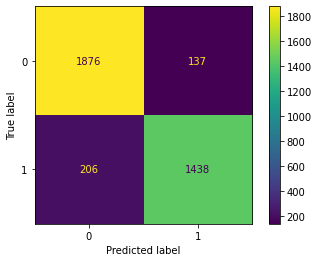

In [128]:
ConfusionMatrixDisplay.from_predictions(preds_t, y_test)

## Achieved 90% accuracy in fake news classification using LSTM RNN with dropout layer and word embedding